In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import seaborn as sns
import json
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from PIL import Image, ImageOps

    
device = torch.device("cuda" )
print(torch.cuda.get_device_name(device))
print(f"Using device: {device}")

NVIDIA GeForce RTX 4060 Laptop GPU
Using device: cuda


In [5]:
def load_images_from_folder(path,limit=None):
    images = []
    name = []

    foc=0.2
    count=1
    for filename in os.listdir(path):
        if(count == limit ):
            break
        img = Image.open(os.path.join(path, filename))

        if img is not None:
            
            img = img.convert("RGB")
            img.thumbnail((384,192), Image.LANCZOS)
            padded_img = ImageOps.pad(img, (384,192), color=(0, 0, 0)) 

            images.append(padded_img)
            
            name.append(filename.split('_')[1].split('.')[0])
        count+=1
    return images, name

def load_label_from_folder(path,name):
    total_name=pd.DataFrame(np.array(name).copy(),columns=['num'])
    for filename in os.listdir(path):
        type=0
        with open(path+'/'+filename, 'r') as file:
            tmp = json.load(file)
        num=tmp['image_filepath'].split('_')[1].split('.')[0]

        for i in range(len(tmp['tooth'])):
            type+=int(tmp['tooth'][i]['decayed'])

        total_name.loc[total_name['num']==num,'type' ]=(1 if type>0 else 0)

    return total_name

def save_images_with_names(Img, Name, path):
    
    
    for i, (img, name) in enumerate(zip(Img, Name)):
        filename = f"{name}.png"
        filepath = os.path.join(path+filename.split('_')[1].split('.')[0], filename)
        #print(path+filename.split('_')[1].split('.')[0])
        
        #img = Image.fromarray(img)
        img.save(filepath)
        


In [6]:
#이미지 1차 전처리 -> downsampling, 패딩 and 라벨링(num+boolean) ->s나누어 저장장
path='Data/image_train_front'
img,name = load_images_from_folder(path)
print(np.array(img[0]).shape)

path='Data/label_train_front'
total_name=load_label_from_folder(path,name)

total_name['num']=total_name['num'].astype(str)
total_name['type']=total_name['type'].astype(int).astype(str)

total_name['fin_label']=total_name.apply(lambda x: x['num']+'_'+x['type'],axis=1)
tmp=total_name['fin_label'].to_numpy()

path='Data/image_preprocessed_'
save_images_with_names(img,tmp,path)



(192, 384, 3)


[13110, 4836]


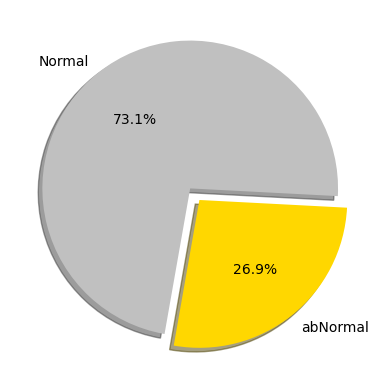

In [2]:
    
path_list=['Data/image_preprocessed_0','Data/image_preprocessed_1']
num_list=[]
for path in path_list:
    count=0
    for filename in os.listdir(path):
        count+=1
    num_list.append(count)
labels = ['Normal', 'abNormal']
explode = [0.05, 0.05]
colors = ['silver', 'gold']
print(num_list)
plt.pie(num_list, labels=labels, autopct='%.1f%%', startangle=260, counterclock=False, explode=explode, shadow=True, colors=colors)

plt.show()

1315.8

In [8]:
import os
import random
import shutil

def create_dataset(path_po, path_ne, output_dir, val_count=1000, test_count=1800):
    pos_files = [os.path.join(path_po, f) for f in os.listdir(path_po) if os.path.isfile(os.path.join(path_po, f))]
    neg_files = [os.path.join(path_ne, f) for f in os.listdir(path_ne) if os.path.isfile(os.path.join(path_ne, f))]
    
    # shuffle
    random.shuffle(pos_files)
    random.shuffle(neg_files)
    
    # Val 
    pos_val = random.sample(pos_files, int(val_count*0.269))
    neg_val = random.sample(neg_files, int(val_count*0.731))
    
    #test /valrhk독립적
    pos_test_candidates = [f for f in pos_files if f not in pos_val]
    neg_test_candidates = [f for f in neg_files if f not in neg_val]
    
    pos_test = random.sample(pos_test_candidates, int(test_count*0.269))
    neg_test = random.sample(neg_test_candidates, int(test_count*0.731))
    
    # 나머지=train
    pos_train = [f for f in pos_files if f not in pos_val and f not in pos_test]
    neg_train = [f for f in neg_files if f not in neg_val and f not in neg_test]
    
    #정리
    train_dir = os.path.join(output_dir, 'train')
    val_dir = os.path.join(output_dir, 'val')
    test_dir = os.path.join(output_dir, 'test')
    
    for d in [train_dir, val_dir, test_dir]:
        os.makedirs(os.path.join(d, '1'), exist_ok=True)
        os.makedirs(os.path.join(d, '0'), exist_ok=True)
    
    def copy_files(file_list, destination):
        for file_path in file_list:
            shutil.copy(file_path, destination)
    
    copy_files(pos_train, os.path.join(train_dir, '1'))
    copy_files(neg_train, os.path.join(train_dir, '0'))
    
    copy_files(pos_val, os.path.join(val_dir, '1'))
    copy_files(neg_val, os.path.join(val_dir, '0'))
    
    copy_files(pos_test, os.path.join(test_dir, '1'))
    copy_files(neg_test, os.path.join(test_dir, '0'))

path_list=['Data/image_preprocessed_0','Data/image_preprocessed_1']
path_po = path_list[1]
path_ne = path_list[0]
output_dir = 'output_dataset'

create_dataset(path_po, path_ne, output_dir)

[13110, 4836]


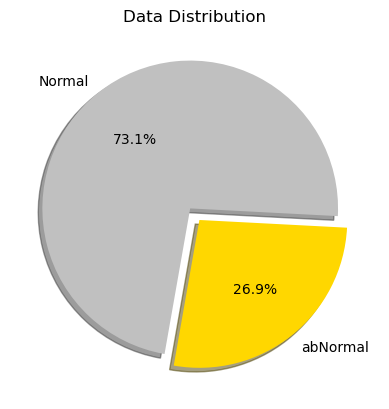

In [81]:
    
path_list=['Data/image_preprocessed_0','Data/image_preprocessed_1']
num_list=[]
for path in path_list:
    count=0
    for filename in os.listdir(path):
        count+=1
    num_list.append(count)
labels = ['Normal', 'abNormal']
explode = [0.05, 0.05]
colors = ['silver', 'gold']
print(num_list)
plt.pie(num_list, labels=labels, autopct='%.1f%%', startangle=260, counterclock=False, explode=explode, shadow=True, colors=colors)
plt.title("Data Distribution")

plt.show()

In [ ]:
path="output_dataset/"
dataset=['train','val','test']
label=['/0','/1']
total={'train':[],
       'val':[],
       'test':[]}
for i in dataset:
    for l in label:
        count=0
        for filename in os.listdir(path+i+l):
            count+=1
        total[i].append(count)
    total[i].append(sum(total[i]))
outer=[]
inner=[]
for i in dataset:
    outer.append(total[i][2])
    inner.append(total[i][:2])

            

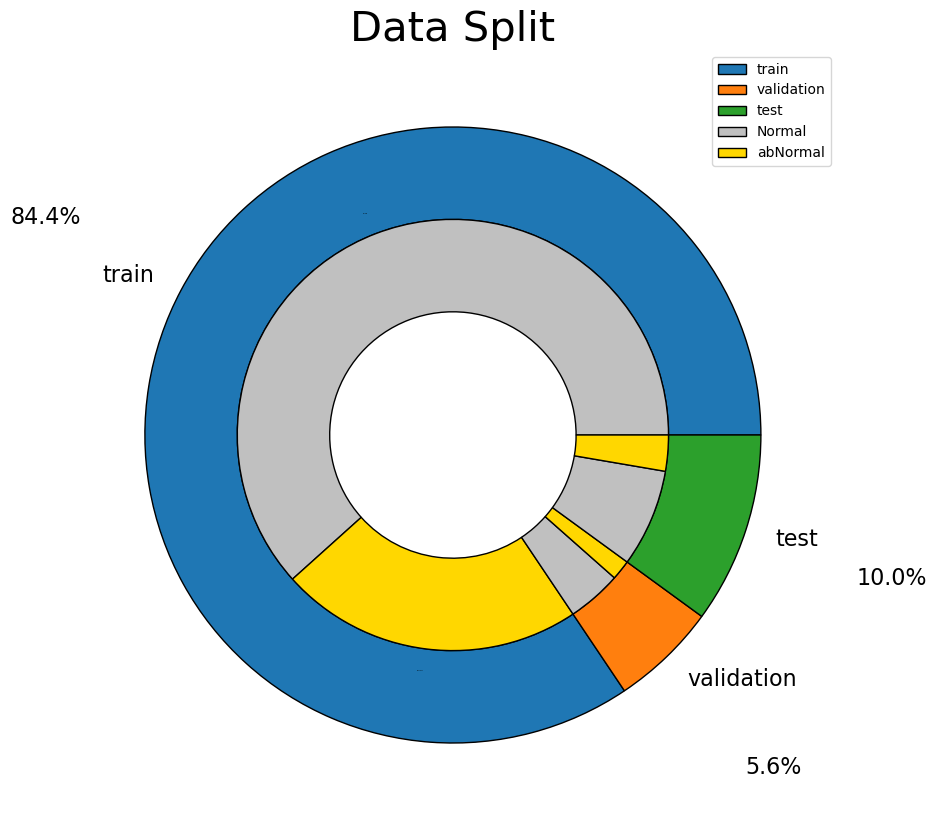

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))

vals = np.array(inner)

size = 0.3
outer_colors = ['tab:blue','tab:orange','tab:green']
inner_colors = ['silver', 'gold']


ax.pie(vals.sum(axis=1), labels=['train','validation','test'], autopct='%.1f%%', radius=1, colors=outer_colors,
       wedgeprops=dict(width=size, edgecolor='black'),pctdistance=1.5,textprops={'fontsize': 16})

ax.pie(vals.flatten(),
       radius=1-size, colors=inner_colors,labels=["Normal","abNormal","","","",""],
       wedgeprops=dict(width=size, edgecolor='black'),textprops={'fontsize': 0})


ax.legend()#['silver', 'gold'], labels=["Normal","abNormal"], loc=(0.5,0.5))

ax.set_title("Data Split",fontsize=30)
ax.set_axis_off()


plt.show()